# TP Coding an autoencoder in Pytorch

Author : Alasdair Newson

alasdair.newson@telecom-paris.fr

## Objective:

The goal of this TP is to explore autoencoders and variational autoencoders applied to a simple dataset. In this first part, we will look at an autoencoder applied to MNIST. We recall that an autoencoder is a neural network with the following general architecture:

![AUTOENCODER](https://perso.telecom-paristech.fr/anewson/doc/images/autoencoder_illustration_2.png)

The tensor $z$ in the middle of the network is called a __latent code__, and it belongs to the latent space. It is this latent space which is interesting in autoencoders (for image synthesis, editing, etc).

### Your task:
You need to add the missing parts in the code (parts between # --- START CODE HERE and # --- END CODE HERE or # FILL IN CODE)


First of all, let's load some packages

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

import pdb
import numpy as np
import matplotlib.pyplot as plt

def pytorch_to_numpy(x):
  return x.detach().numpy()

Now, we load the MNIST dataset, which we will use for training a simple autoencoder.

In [27]:
# MNIST Dataset
mnist_trainset = datasets.MNIST(root='mnist_data', train=True, transform=transforms.ToTensor(), download=True)
mnist_testset = datasets.MNIST(root='mnist_data', train=False, transform=transforms.ToTensor(), download=False)

#create data loader with smaller dataset size
max_mnist_size = 1000
mnist_trainset_reduced = torch.utils.data.random_split(mnist_trainset, [max_mnist_size, len(mnist_trainset)-max_mnist_size])[0] 
mnist_train_loader = torch.utils.data.DataLoader(mnist_trainset_reduced, batch_size=256, shuffle=True,drop_last=True)

# download test dataset
max_mnist_size = 512
mnist_testset_reduced = torch.utils.data.random_split(mnist_testset, [max_mnist_size, len(mnist_testset)-max_mnist_size])[0] 
mnist_test_loader = torch.utils.data.DataLoader(mnist_testset_reduced, batch_size=256, shuffle=True,drop_last=True)


In [98]:
len(mnist_trainset_reduced)

1000

# 1 Vanilla Autoencoder

Now, we define the general parameters of our autoencoder. In particular, we note that the latent space is of size 10. We have chosen this since there are 10 digits, but you can change this as you wish.

In [29]:
# autoencoder parameters
n_rows = mnist_trainset_reduced.dataset.train_data.shape[1]
n_cols = mnist_trainset_reduced.dataset.train_data.shape[2]
n_channels = 1
n_pixels = n_rows*n_cols

img_shape = (n_rows, n_cols, n_channels)
z_dim = 25
n_epochs = 100

Now, define the autoencoder architecture by creating a Pytorch class. We will use the following MLP architecture :

Encoder :
- Flatten input
- Dense layer $+$ ReLU
- Dense layer $+$ ReLU
- Dense layer (no non-linearity), output size ```z_dim```

Decoder :
- Dense layer $+$ ReLU
- Dense layer $+$ ReLU
- Dense layer $+$ Sigmoid Activation
- Reshape, to size $28\times 28\times 1$

The intermediate dimensions are referred to as ```h_dim_1``` and ```h_dim2```. For the reshape operation (and even the flatten), you can use the __view__ operation of Pytorch, for example:
- ```x.view(-1,n_channels, n_rows,n_cols)```

You can use the ```F.relu()``` function for the ReLU non-linearity (or any other choice you like).

In [30]:
class AE(torch.nn.Module ):
  def __init__(self, x_dim, h_dim1, h_dim2, z_dim,n_rows,n_cols,n_channels):
    super(AE, self).__init__()

    self.n_rows = n_rows
    self.n_cols = n_cols
    self.n_channels = n_channels
    self.n_pixels = (self.n_rows)*(self.n_cols)
    self.z_dim = z_dim

    # encoder part
    self.fc1 = nn.Linear(x_dim, h_dim1) # FILL IN STUDENT 
    self.fc2 = nn.Linear(h_dim1, h_dim2) # FILL IN STUDENT 
    self.fc3 = nn.Linear(h_dim2, z_dim) # FILL IN STUDENT 
    # decoder part
    self.fc4 = nn.Linear(z_dim, h_dim2) # FILL IN STUDENT 
    self.fc5 = nn.Linear(h_dim2, h_dim1) # FILL IN STUDENT 
    self.fc6 = nn.Linear(h_dim1, x_dim) # FILL IN STUDENT 

  def encoder(self, x):
    h = F.relu(self.fc1(x.view(x.size(0), -1)))  #FILL IN STUDENT 
    h = F.relu(self.fc2(h)) # FILL IN STUDENT 
    return self.fc3(h) # FILL IN STUDENT 
  def decoder(self, z):
    h = F.relu(self.fc4(z)) # FILL IN STUDENT 
    h = F.relu(self.fc5(h)) # FILL IN STUDENT 
    return torch.sigmoid(self.fc6(h)).view(-1,n_channels, n_rows,n_cols) # FILL IN STUDENT 

  def forward(self, x):
    y = self.decoder(self.encoder(x)) # FILL IN STUDENT 
    return(y)
    
  def loss_function(self,x, y):
    bce_loss = F.binary_cross_entropy(x, y) # FILL IN STUDENT 
    return torch.mean(bce_loss)

In [31]:
# create an instance of the model
ae_dim_1 = 512
ae_dim_2 = 256
ae_model = AE(x_dim=n_pixels, h_dim1= ae_dim_1, h_dim2=ae_dim_2, z_dim=z_dim,n_rows=n_rows,n_cols=n_cols,n_channels=n_channels)
ae_optimizer = optim.Adam(ae_model.parameters(), lr=1e-4)

Now, define a generic function to train the model for one epoch

In [32]:
def train_ae(ae_model,data_train_loader,epoch):
	train_loss = 0
	for batch_idx, (data, _) in enumerate(data_train_loader):
		ae_optimizer.zero_grad()
		
		y = ae_model.forward(data) # FILL IN STUDENT 
		loss_ae = ae_model.loss_function(y, data) # FILL IN STUDENT 
  
		loss_ae.backward()
		train_loss += loss_ae.item()
		ae_optimizer.step()
		
		if batch_idx % 100 == 0:
			print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
				epoch, batch_idx * len(data), len(data_train_loader.dataset),
				100. * batch_idx / len(data_train_loader), loss_ae.item() / len(data)))
	print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(data_train_loader.dataset)))


Finally, train the model for ```n_epochs``` epochs

In [33]:
for epoch in range(0, n_epochs):
  train_ae(ae_model,mnist_train_loader,epoch)

Train Epoch: 0 [0/1000 (0%)]	Loss: 0.002707
====> Epoch: 0 Average loss: 0.0021
Train Epoch: 1 [0/1000 (0%)]	Loss: 0.002700
====> Epoch: 1 Average loss: 0.0021
Train Epoch: 2 [0/1000 (0%)]	Loss: 0.002691
====> Epoch: 2 Average loss: 0.0021
Train Epoch: 3 [0/1000 (0%)]	Loss: 0.002682
====> Epoch: 3 Average loss: 0.0021
Train Epoch: 4 [0/1000 (0%)]	Loss: 0.002669
====> Epoch: 4 Average loss: 0.0020
Train Epoch: 5 [0/1000 (0%)]	Loss: 0.002653
====> Epoch: 5 Average loss: 0.0020
Train Epoch: 6 [0/1000 (0%)]	Loss: 0.002632
====> Epoch: 6 Average loss: 0.0020
Train Epoch: 7 [0/1000 (0%)]	Loss: 0.002603
====> Epoch: 7 Average loss: 0.0020
Train Epoch: 8 [0/1000 (0%)]	Loss: 0.002563
====> Epoch: 8 Average loss: 0.0020
Train Epoch: 9 [0/1000 (0%)]	Loss: 0.002505
====> Epoch: 9 Average loss: 0.0019
Train Epoch: 10 [0/1000 (0%)]	Loss: 0.002428
====> Epoch: 10 Average loss: 0.0018
Train Epoch: 11 [0/1000 (0%)]	Loss: 0.002318
====> Epoch: 11 Average loss: 0.0017
Train Epoch: 12 [0/1000 (0%)]	Loss: 

In [110]:
# some functions to display images and autoencoded images

def display_images(imgs):
  
  r = 1
  c = imgs.shape[0]
  fig = plt.figure(figsize=(15, 5))
  axs = fig.subplots(r, c)
  for j in range(c):
    #black and white images
    axs[j].imshow(pytorch_to_numpy(imgs[j, 0,:,:]), cmap='gray')
    axs[j].axis('off')
  plt.show()

def display_ae_images(ae_model, test_imgs):
  n_images = 5
  idx = np.random.randint(0, test_imgs.shape[0], n_images)
  test_imgs = test_imgs[idx,:,:,:]
  print(test_imgs.shape)

  #get output images
  output_imgs = pytorch_to_numpy(ae_model.forward( test_imgs ))
  print(output_imgs.shape)
  
  r = 2
  c = n_images
  fig, axs = plt.subplots(r, c)
  for j in range(c):
    #black and white images
    axs[0,j].imshow(test_imgs[j, 0,:,:], cmap='gray')
    axs[0,j].axis('off')
    axs[1,j].imshow(output_imgs[j, 0,:,:], cmap='gray')
    axs[1,j].axis('off')
  plt.show()

torch.Size([5, 1, 28, 28])
(5, 1, 28, 28)


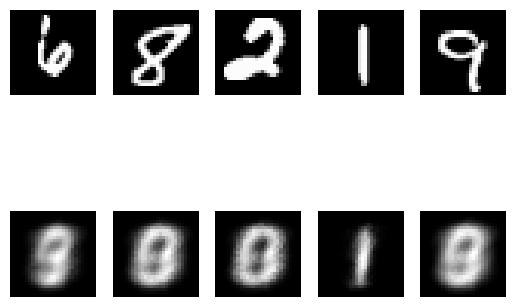

In [35]:
test_imgs = next(iter(mnist_train_loader))[0]
display_ae_images(ae_model, test_imgs)

Do these autoencoded images look good to you ? You can try to change the latent space size to see if the results improve. 

# 2/ Variational autoencoder

Now, we are going to create an variational autoencoder to carry out __image generation__. Let's first recall the idea of a variational autoencoder

## Main idea

The main idea is to create an autoencoder whose latent codes follow a certain distribution (a Gaussian distribution in practice). This is done with two tools : 

- A specific architecture, where the encoder produces the average and variance of the latent codes
- A specially designed loss function

Once the VAE is trained, it is possible to sample in the latent space by producing random normal variables and simply decoding.

## Architecture

The architecture of the VAE model is as follows:

The encoder consists of:

Encoder :
- Flatten input
- Dense layer $+$ ReLU
- Dense layer $+$ ReLU
- Dense layer (no non-linarity) to produce the average, Dense layer (no non-linarity) to produce the variance (these last two layers are in parallel)

Decoder :
- Dense layer $+$ ReLU
- Dense layer $+$ ReLU
- Dense layer $+$ Sigmoid Activation
- Reshape, to size $28\times 28\times 1$


## Variational Autoencoder loss

Recall that for the VAE, the loss function is in fact a function to __maximise__. In fact, for implementation, you will see that it is easier to __minimise__ $-\mathcal{L}$.

In the case of an image which is represented by a set of __Bernoulli__ variables (which is relevant for mnist), the original loss function (to maximise) is written :


\begin{align}
\mathcal{L} &= \log\left(p_\theta(x|z)\right) - KL\left( q_\phi(z|x) \; || \; p_\theta(z)\right) \\
    &= \left(\sum_{i} x_i \log y_i + (1-x_i) \log (1-y_i)\right) - \left(\frac{1}{2} \sum_j \left( \sigma_j^2 + \mu_j^2 - \log \sigma_j^2 -1 \right)\right)
\end{align}


where $i$ is summed over the image pixels, and $j$ is summed over the elements of the latent space. $\sigma_j^2$ is the $j$th element of the latent space variance, and $\mu_j$ is the $j$th element of the latent space mean.

The left part of the loss (reconstruction error) can be implemented simply as the binary cross-entropy between the input x and the output y. Since we are __maximising__ $-$[binary cross-entropy] (look at the formula), this is equivalent to minimising the binary cross-entropy.

For the right part of the equation (KL divergence), you need to implement it manually. 

The final loss is the average, over the batch size, of the sum of the reconstruction error (left part) and the KL divergence (right part). Be careful, in the formula, the sums over $i$ and $j$ are over the number of pixels and the number of latent elements, respectively. To achieve a sum rather than an average, you can use ```torch.nn.BCELoss(reduction='sum')()```, and the ```torch.sum()``` functions.

As in the case of the normal autoencoder, you will need to flatten and then reshape the tensors at the beginning/end of the network.

In [49]:
class VAE(torch.nn.Module ):
  def __init__(self, x_dim, h_dim1, h_dim2, z_dim,n_rows,n_cols,n_channels):
    super(VAE, self).__init__()

    self.n_rows = n_rows
    self.n_cols = n_cols
    self.n_channels = n_channels
    self.n_pixels = (self.n_rows)*(self.n_cols)
    self.z_dim = z_dim

    # encoder part
    self.fc1 = torch.nn.Linear(self.n_pixels, h_dim1) #FILL IN STUDENT
    self.fc2 = torch.nn.Linear(h_dim1, h_dim2) #FILL IN STUDENT
    self.fc31 = torch.nn.Linear(h_dim2, z_dim) #FILL IN STUDENT
    self.fc32 = torch.nn.Linear(h_dim2, z_dim) #FILL IN STUDENT
    # decoder part
    self.fc4 = torch.nn.Linear(z_dim, h_dim2) #FILL IN STUDENT
    self.fc5 = torch.nn.Linear(h_dim2, h_dim1) #FILL IN STUDENT
    self.fc6 = torch.nn.Linear(h_dim1, self.n_pixels) #FILL IN STUDENT

  def encoder(self, x):
    h = torch.relu(self.fc1(x)) #FILL IN STUDENT
    h = torch.relu(self.fc2(h)) #FILL IN STUDENT
    return self.fc31(h), self.fc32(h) #FILL IN STUDENT (remember, there are two outputs)
  def decoder(self, z):
    h = torch.relu(self.fc4(z)) #FILL IN STUDENT
    h = torch.relu(self.fc5(h)) #FILL IN STUDENT
    return torch.sigmoid(self.fc6(h)).view(-1,n_channels, n_rows,n_cols) #FILL IN STUDENT

  def sampling(self, mu, log_var):
    # this function samples a Gaussian distribution, with average (mu) and standard deviation specified (using log_var)
    std = torch.exp(0.5*log_var)
    eps = torch.randn_like(std)
    return eps.mul(std).add_(mu) # return z sample

  def forward(self, x):
    z_mu, z_log_var = self.encoder(x.view(-1, self.n_pixels)) #FILL IN STUDENT
    z = self.sampling(z_mu, z_log_var) #FILL IN STUDENT
    return self.decoder(z),z_mu, z_log_var

  def loss_function(self,x, y, mu, log_var):
    reconstruction_error = F.binary_cross_entropy(y.view(-1, self.n_pixels), x.view(-1, self.n_pixels), reduction='sum') #FILL IN STUDENT
    #reconstruction_error =  torch.nn.MSELoss(reduction='sum')(y.view(-1,self.n_pixels),x.view(-1,self.n_pixels))#F.binary_cross_entropy(y.view(-1,self.n_pixels),x.view(-1,self.n_pixels), reduction='sum')
    
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) #FILL IN STUDENT


    return reconstruction_error + KLD #FILL IN STUDENT

Now, create the model (similarly as above)

In [50]:
# create model
vae_dim_1 = ae_dim_1
vae_dim_2 = ae_dim_2
vae_model = VAE(x_dim=n_pixels, h_dim1= vae_dim_1, h_dim2=vae_dim_2, z_dim=z_dim,n_rows=n_rows,n_cols=n_cols,n_channels=n_channels)
vae_optimizer = optim.Adam(vae_model.parameters())

Finally, train the model. First modify the training function to the case of the vae.

In [51]:
def train_vae(vae_model,data_train_loader,epoch):
  train_loss = 0
  for batch_idx, (data, _) in enumerate(data_train_loader):
    vae_optimizer.zero_grad()

    y, z_mu, z_log_var = vae_model(data) #FILL IN STUDENT
    loss_vae = vae_model.loss_function(data, y, z_mu, z_log_var) #FILL IN STUDENT
    loss_vae.backward()
    train_loss += loss_vae.item()
    vae_optimizer.step() 
		
    if batch_idx % 100 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
      epoch, batch_idx * len(data), len(data_train_loader.dataset),
      100. * batch_idx / len(data_train_loader), loss_vae.item() / len(data)))
  print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(data_train_loader.dataset)))


In [149]:
n_epochs = 300

In [150]:
# now train the model
for epoch in range(0, n_epochs):
  train_vae(vae_model,mnist_train_loader,epoch)

Train Epoch: 0 [0/1000 (0%)]	Loss: 140.012634
====> Epoch: 0 Average loss: 111.0660
Train Epoch: 1 [0/1000 (0%)]	Loss: 144.390869
====> Epoch: 1 Average loss: 111.6866
Train Epoch: 2 [0/1000 (0%)]	Loss: 148.084961
====> Epoch: 2 Average loss: 110.8087
Train Epoch: 3 [0/1000 (0%)]	Loss: 143.028412
====> Epoch: 3 Average loss: 110.2525
Train Epoch: 4 [0/1000 (0%)]	Loss: 146.614166
====> Epoch: 4 Average loss: 111.2295
Train Epoch: 5 [0/1000 (0%)]	Loss: 143.869553
====> Epoch: 5 Average loss: 110.0758
Train Epoch: 6 [0/1000 (0%)]	Loss: 146.019562
====> Epoch: 6 Average loss: 109.7767
Train Epoch: 7 [0/1000 (0%)]	Loss: 145.567963
====> Epoch: 7 Average loss: 110.1737
Train Epoch: 8 [0/1000 (0%)]	Loss: 139.882523
====> Epoch: 8 Average loss: 109.1992
Train Epoch: 9 [0/1000 (0%)]	Loss: 147.182663
====> Epoch: 9 Average loss: 109.4807
Train Epoch: 10 [0/1000 (0%)]	Loss: 143.154190
====> Epoch: 10 Average loss: 108.9373
Train Epoch: 11 [0/1000 (0%)]	Loss: 142.276962
====> Epoch: 11 Average los

Now, generate some images with the VAE model

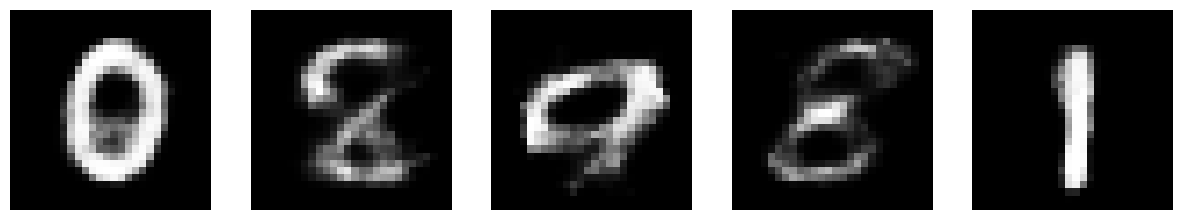

In [151]:
def generate_images_vae(vae_model,n_images = 5):
  epsilon = torch.randn(n_images,1,vae_model.z_dim)
  imgs_generated = vae_model.decoder(epsilon)
  return(imgs_generated)

imgs_generated = generate_images_vae(vae_model,n_images=5)
display_images(imgs_generated)

What do you think of the results ? You can try and change the latent space size, or use convolutional layers instead to improve the results.

In [130]:
class RBM:

  def __init__(self, p, q):
    self.a = np.zeros(p)
    self.b = np.zeros(q)
    self.W = np.random.normal(loc=0.0, scale=0.1, size=(p, q))

  def entree_sortie_RBM(self, X):
    return 1/(1 + np.exp(-(X@self.W + self.b)))

  def sortie_entree_RBM(self, H):
    return 1/( 1 + np.exp(-(H@self.W.T + self.a)))

  def train_RBM(self, X, epsilon, batch_size, nb_epochs):
    p = self.a.shape[0]
    q = self.b.shape[0]
    n = np.size(X, 0)
    shuffle_index = np.arange(n)
    error = []
    for epoch in range(0, nb_epochs):
      np.random.shuffle(shuffle_index)
      x = X[shuffle_index]
      for i in range(0, n, batch_size):
        X_batch = x[i: min(i+batch_size, n-1), :]
        tb = np.size(X_batch, 0)

        v_0 = X_batch
        p_h_v_0 = self.entree_sortie_RBM(v_0)
        h_0 = (np.random.rand(tb, q) < p_h_v_0) * 1

        p_v_h_0 = self.sortie_entree_RBM(h_0)
        v_1 = (np.random.rand(tb, p) < p_v_h_0) * 1
        p_h_v_1 = self.entree_sortie_RBM(v_1)

        grad_a = np.sum(v_0-v_1, axis=0)
        grad_b = np.sum(p_h_v_0-p_h_v_1, axis=0)
        grad_W = v_0.T@p_h_v_0 - v_1.T@p_h_v_1

        self.a += (epsilon / tb) * grad_a
        self.b += (epsilon / tb) * grad_b
        self.W += (epsilon / tb) * grad_W

      H = self.entree_sortie_RBM(X)
      X_rec = self.sortie_entree_RBM(H)
      err = np.sum((X - X_rec) ** 2) / n
      error.append(err)
      print("l'erreur à l'epoch " + str(epoch) + " est :" + str(err))
    return error

  def generer_image_RBM(self, nb_data, nb_gibbs):
    p = self.a.shape[0]
    q = self.b.shape[0]
    fig, axs = plt.subplots(1, nb_data, figsize=(15, 5), constrained_layout=True)
    for i in range(0, nb_data):
        v = (np.random.rand(p) < 0.5) * 1
        for iter_gibbs in range(0, nb_gibbs):
            h = (np.random.rand(q) < self.entree_sortie_RBM(v)) * 1
            v = (np.random.rand(p) < self.sortie_entree_RBM(h)) * 1
        v = v.reshape(28, 28)
        axs[i].imshow(v, cmap='gray')
        axs[i].axis('off')
    plt.show()

In [131]:
from idx2numpy import convert_from_file

In [136]:
X_train = convert_from_file("mnist_data/raw/train-images-idx3-ubyte")
X_train = X_train.reshape(X_train.shape[0], -1)
X_train = np.array(X_train > 0.5, dtype=np.int8)

X_test = convert_from_file("mnist_data/raw/t10k-images-idx3-ubyte")
X_test = X_test.reshape(X_test.shape[0], -1)
X_test = np.array(X_test > 0.5, dtype=np.int8)

label_training = convert_from_file("mnist_data/raw/train-labels-idx1-ubyte")
label_training = np.eye(10)[label_training]

label_test = convert_from_file("mnist_data/raw/t10k-labels-idx1-ubyte")
label_test = np.eye(10)[label_test]

In [137]:
import random

def get_random_samples(X, k=1000):
  n = np.size(X, 0)
  indices = np.arange(n)
  np.random.shuffle(indices)
  sampled_indices = indices[:k]
  return X[sampled_indices]

In [138]:
X_train = get_random_samples(X_train, 1000)

In [152]:
rbm = RBM(np.size(X_train, 1), 300)
error = rbm.train_RBM(X_train, epsilon=0.1, batch_size=32, nb_epochs=300)

l'erreur à l'epoch 0 est :54.871593493588975
l'erreur à l'epoch 1 est :43.95764591920783
l'erreur à l'epoch 2 est :37.04369413915457
l'erreur à l'epoch 3 est :33.08668035988388
l'erreur à l'epoch 4 est :31.387546889191857
l'erreur à l'epoch 5 est :28.706311611450932
l'erreur à l'epoch 6 est :26.322831785700032
l'erreur à l'epoch 7 est :26.185680415100098
l'erreur à l'epoch 8 est :24.155622410400188
l'erreur à l'epoch 9 est :23.285276003241474
l'erreur à l'epoch 10 est :21.782543071525396
l'erreur à l'epoch 11 est :21.362774690549895
l'erreur à l'epoch 12 est :20.740830178915534
l'erreur à l'epoch 13 est :20.303864180750086
l'erreur à l'epoch 14 est :19.25229505444621
l'erreur à l'epoch 15 est :18.6282201041795
l'erreur à l'epoch 16 est :18.532131825858226
l'erreur à l'epoch 17 est :17.886428152100518
l'erreur à l'epoch 18 est :17.302103273092296
l'erreur à l'epoch 19 est :16.94858692804165
l'erreur à l'epoch 20 est :16.218366938532082
l'erreur à l'epoch 21 est :15.607716202542688
l'err

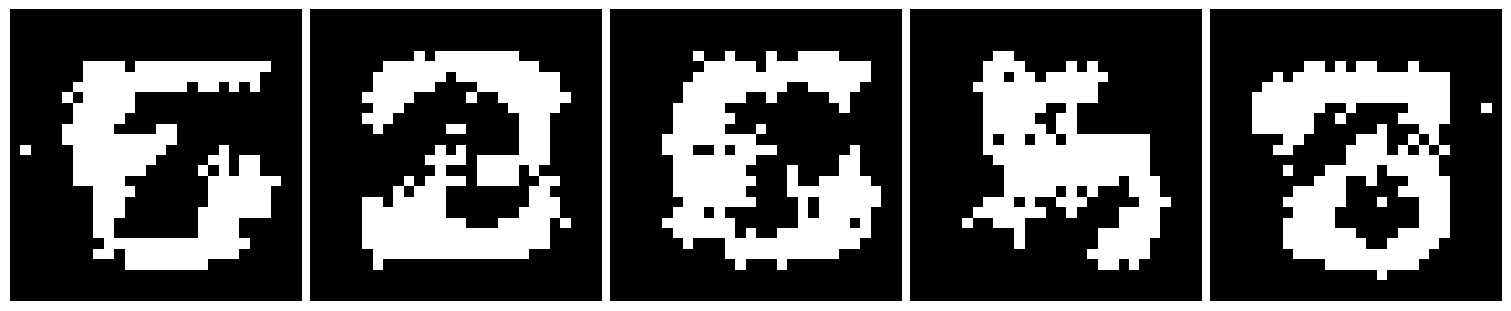

In [153]:
rbm.generer_image_RBM(nb_data=5, nb_gibbs=20)

In [154]:
class DBN:

  def __init__(self, config):
    self.nb_layers = len(config)
    self.rbms = []
    for i in range(self.nb_layers - 1):
      self.rbms.append(RBM(config[i], config[i+1]))

  def train_DBN(self, X, epsilon, batch_size, nb_epochs):
    error = []
    for i in range(self.nb_layers - 1):
      print('Layer' + str(i))
      err = self.rbms[i].train_RBM(X, epsilon, batch_size, nb_epochs)
      error.append(err)
      X = self.rbms[i].entree_sortie_RBM(X)
    return error
    
  def generer_image_DBN(self, nb_data, nb_gibbs):
    p = self.rbms[-1].a.shape[0]
    q = self.rbms[-1].b.shape[0]
    
    fig, axs = plt.subplots(1, nb_data, figsize=(15, 5), constrained_layout=True)
    for i in range(0, nb_data):
        v = (np.random.rand(p) < 0.5) * 1

        for iter_gibbs in range(0, nb_gibbs):
            h = (np.random.rand(q) < self.rbms[-1].entree_sortie_RBM(v)) * 1
            v = (np.random.rand(p) < self.rbms[-1].sortie_entree_RBM(h)) * 1

        for j in range(self.nb_layers - 2, -1, -1):
            c = self.rbms[j].sortie_entree_RBM(v)
            v = (np.random.rand(self.rbms[j].a.shape[0]) < c) * 1     

        v = v.reshape(28, 28)
        axs[i].imshow(v, cmap='gray')
        axs[i].axis('off')
    plt.show()

  '''def generer_image_DBN(self, nb_data, nb_gibbs):
    p = self.rbms[-1].a.shape[0]
    q = self.rbms[-1].b.shape[0]

    for i in range(0, nb_data):
      v = (np.random.rand(p) < 0.5) * 1

      for iter_gibbs in range(0, nb_gibbs):
        h = (np.random.rand(q) < self.rbms[-1].entree_sortie_RBM(v)) * 1
        v = (np.random.rand(p) < self.rbms[-1].sortie_entree_RBM(h)) * 1

      for j in range(self.nb_layers - 2, -1, -1):
        c = self.rbms[j].sortie_entree_RBM(v)
        v = (np.random.rand(self.rbms[j].a.shape[0]) < c) * 1     
     
      v = v.reshape(28, 28)
      plt.imshow(v, cmap='gray')
      plt.show()'''

In [155]:
p = X_train.shape[1]
q = 100

In [156]:
dbn =  DBN([p, 100, 100, q])
error = dbn.train_DBN(X_train, epsilon=0.1, batch_size=32, nb_epochs=300)

Layer0
l'erreur à l'epoch 0 est :59.75434309707805
l'erreur à l'epoch 1 est :49.075232890444184
l'erreur à l'epoch 2 est :45.9692434669236
l'erreur à l'epoch 3 est :42.43578395101134
l'erreur à l'epoch 4 est :38.990821045976055
l'erreur à l'epoch 5 est :37.521358701596
l'erreur à l'epoch 6 est :36.01959717336292
l'erreur à l'epoch 7 est :34.81314545417928
l'erreur à l'epoch 8 est :33.77631966899554
l'erreur à l'epoch 9 est :32.22409135245946
l'erreur à l'epoch 10 est :32.21076423474382
l'erreur à l'epoch 11 est :30.365738232193372
l'erreur à l'epoch 12 est :30.019592261418126
l'erreur à l'epoch 13 est :29.158903521787625
l'erreur à l'epoch 14 est :28.943603405303758
l'erreur à l'epoch 15 est :27.995070244910572
l'erreur à l'epoch 16 est :27.850228852108824
l'erreur à l'epoch 17 est :27.237956471895757
l'erreur à l'epoch 18 est :26.506953553167573
l'erreur à l'epoch 19 est :26.506278043892138
l'erreur à l'epoch 20 est :25.63625981663217
l'erreur à l'epoch 21 est :25.853991319989706
l'er

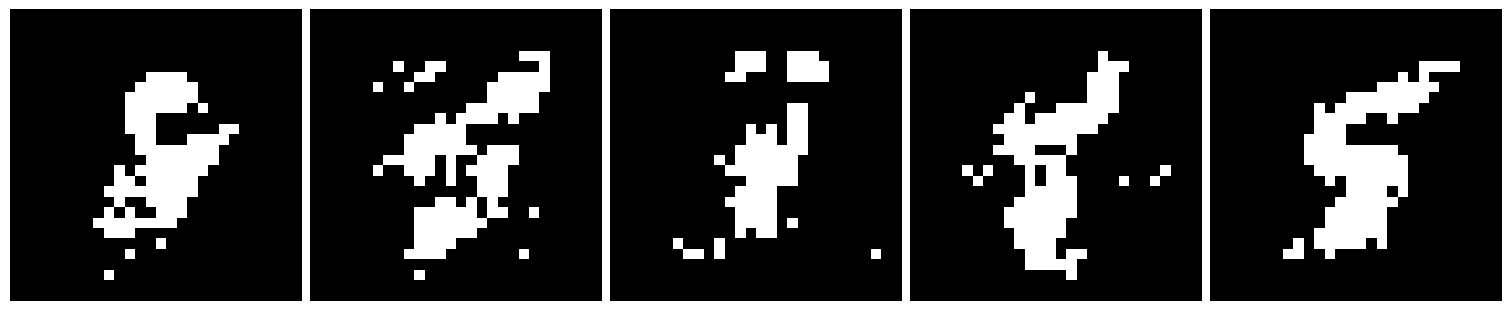

In [157]:
dbn.generer_image_DBN(5,20)